# Volume changes in drying ribbons vs isolated embryos

We wanted to know if a) embryos in drying ribbons experience the salinity change that one would expect based on the amount of water loss, and 2) if embryo volume (V) change in response to the salinity change in the same way that it would in isolated embryos. This suggests the following hypothesis:

H1: $\ V_{ribbon}(expected salinity) = V_{isolated}(measured salinity) $

We don't know how V varies with salinity, but we can take the 'ideal osmometer' as a starting point, which suggests: $ V = a/salinity + b $

So to test H1, we can do linear regression of embryo volume with 1/salinity\*, to test the null hypothesis that there is no effect of treatment (ribbon vs isolated) or interaction effect of treatment and 1/salinity.

Then, check for outliers and (visually) check for non-linearity.

\* Salinity is measured by refractometer in the case of the isolated embryos, and estimated based on mass loss in the case of embryos in ribbons. Estimated salinity is the seawater salinity measured with refractometer for ribbons that are not dried, and the seawater salinity multiplied by the initial ribbon weight and divided by final ribbon weight for dried ribbons.

### Steps for analyzing embryo volume files (THIS NOTEBOOK DOES STEPS 4-5)

0) MANUALLY IN EXCEL: Create csv file with embryo image name, treatment (isolated embryos in salt solution or embryos in egg masses), and [expected] salinity.

STEPS 1-3 DONE WITH 'AverageVolumeByRibbons.py' SCRIPT
1) Read individual files: Check that 1) have 10 lines per and correct columns: raise error if they don't.

2) Calculate XY centers of each selection and compare to selection (since index may go off, use positional index rather than ImageJ index). Check that XY centers are within <1 radius of each other.

3) Calculate volume and mean volume per file.

4) Plot volume vs 1/salinity

5) Linear least-squares fit to 1/salinity for each treatment (linear regression model in statsmodel package).

6) Check for outliers.

7) FUTURE: Do fits for individual treatments and compare slopes & following Zar (1999) to check statsmodel outputs.

In [129]:
# Data source used: Zygote data
datafile = 'ZygoteVolumes_AveragedByRibbon.csv'

In [130]:
import pandas
import matplotlib.pyplot as plt
import statsmodels.api as sm
import time
import numpy as np

import os, sys
lib_path = os.path.abspath('..')
sys.path.append(lib_path)
import hambits.stats as hs

from patsy import dmatrices

# Import selected data
consdata = pandas.read_csv(datafile)

tstyle = '%Y %B %d - %I:%M %p'
print('Run on: ', time.strftime(tstyle))
print('data file updated: ', 
      time.strftime(tstyle, time.gmtime(os.path.getmtime(datafile))))

print('data: ')
print(consdata[['File', 'TmntCat', 'Salinity', 'Volume', 'SE_Volume'
                ]].round(decimals={'Salinity': 0, 'Volume': 0, 'SE_Volume': 0,
                                 'InvSalinity': 3}))

Run on:  2016 December 18 - 08:23 PM
data file updated:  2016 December 18 - 11:44 PM
data: 
            File   TmntCat  Salinity  Volume  SE_Volume
0   Z01_meas.xls    ribbon        30  308915      10047
1   Z02_meas.xls  isolated        77  179511       5144
2   Z04_meas.xls  isolated        63  211231       8972
3   Z05_meas.xls  isolated        45  211847       4230
4   Z08_meas.xls  isolated        32  308714      11027
5   Z09_meas.xls  isolated        78  229721       5737
6   Z10_meas.xls    ribbon        59  226462       3397
7   Z11_meas.xls  isolated        32  303878       3739
8   Z12_meas.xls  isolated        63  205285       3385
9   Z13_meas.xls    ribbon        31  287287       6881
10  Z14_meas.xls    ribbon       178  121329       2947
11  Z15_meas.xls  isolated        48  253463       3749
12  Z16_meas.xls  isolated        32  280322       6712
13  Z17_meas.xls  isolated        48  245126      11889
14  Z18_meas.xls  isolated        78  265027       9305
15  Z19_meas

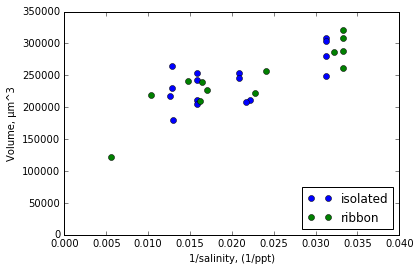

In [131]:
# Generate plots
%matplotlib inline
tmntgrps = consdata.groupby('TmntCat')
# Plot groups (by 1/salinity)
fig1, ax1 = plt.subplots()
for name, group in tmntgrps:
    ax1.plot(group.InvSalinity, group.Volume, marker='o',  linestyle='', markersize=6,
             label=name)
ax1.legend(loc='lower right')
ax1.set_ylabel('Volume, µm^3')
ax1.set_xlabel('1/salinity, (1/ppt)')
ax1.set_ylim((0, 350000))
ax1.set_xlim(0, 0.04);

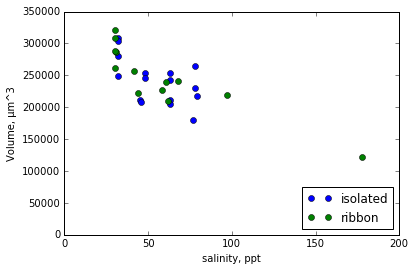

In [132]:
# Plot groups (by salinity)
fig2, ax2 = plt.subplots()
for name, group in tmntgrps:
    ax2.plot(group.Salinity, group.Volume, marker='o', linestyle='', markersize=6,
             label=name)
ax2.legend(loc='lower right')
ax2.set_ylabel('Volume, µm^3')
ax2.set_xlabel('salinity, ppt')
ax2.set_ylim((0, 350000))
ax2.set_xlim(0, 200);

In [133]:
# Analyze with linear regression: Test whether significant effect of TmntCat (ribbon vs isolated)
# or interaction between TmntCat and InvSalinity
y, X = dmatrices('Volume ~ TmntCat + InvSalinity + InvSalinity:TmntCat',
                 data=consdata, return_type='dataframe')
mod = sm.OLS(y, X)  # Describe model
regression_result = mod.fit()  # Fit model
print(regression_result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Volume   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     15.23
Date:                Sun, 18 Dec 2016   Prob (F-statistic):           7.66e-06
Time:                        20:23:29   Log-Likelihood:                -334.99
No. Observations:                  29   AIC:                             678.0
Df Residuals:                      25   BIC:                             683.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept     

In [134]:
# Check for outliers (first term in dict is number of outliers)
outlierresults = hs.GeneralizedESD(regression_result.resid.values, 10,
                                   Alpha=0.05)
print('Number of outliers detected: ', outlierresults[0])
print(pandas.DataFrame(outlierresults[1]))

Number of outliers detected:  None
      MaxRs  MaxRsInd     Rcrit          Vals
0  1.921751        14  2.892705  48331.878528
1  1.914297        10  2.876209 -47377.260829
2  1.701545        15  2.858923 -38451.089975
3  1.806384         1  2.840774 -37735.145208
4  1.889319         3  2.821681 -35955.871288
5  2.046774        28  2.801551 -35117.341998
6  1.960733        19  2.780277 -28816.660702
7  2.014350        27  2.757735 -25608.273676
8  2.027921         8  2.733780 -21510.319263
9  1.906538         2  2.708246 -15564.434083


In [135]:
# Test if makes a difference if drop value with exceptionally high salinity
consdata2 = consdata.drop(consdata[consdata['File'] == 'Z14_meas.xls'].index)
y2, X2 = dmatrices('Volume ~ TmntCat + InvSalinity + InvSalinity:TmntCat',
                   data=consdata2, return_type='dataframe')
mod2 = sm.OLS(y2, X2)  # Describe model
regression_result2 = mod2.fit()  # Fit model
print(regression_result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Volume   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     11.34
Date:                Sun, 18 Dec 2016   Prob (F-statistic):           7.96e-05
Time:                        20:23:29   Log-Likelihood:                -321.15
No. Observations:                  28   AIC:                             650.3
Df Residuals:                      24   BIC:                             655.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept     

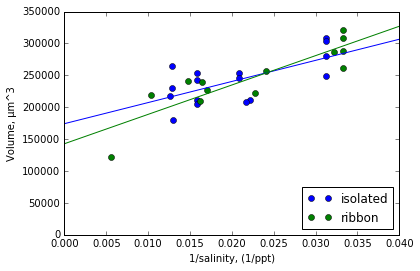

In [136]:
# Plot with lines that were fit to all data.
xlims=[0,0.04]
iso1 = ax1.plot(xlims, regression_result.predict(np.array([[1,0,xlims[0],0],
                                                           [1,0,xlims[1],0]])), color='b')
rib1 = ax1.plot(xlims, regression_result.predict(np.array([[1,1,xlims[0],xlims[0]],
                                                           [1,1,xlims[1], xlims[1]]])), color='g')
fig1

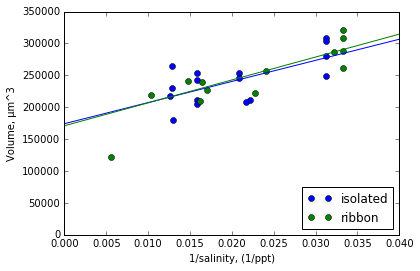

In [137]:
# Plot with lines that were fit to data with extreme salinity (lowest 1/salinity) point removed.
xlims=[0,0.04]
# remove last two lines added
del ax1.lines[-2:]
ax1.plot(xlims, regression_result2.predict(np.array([[1,0,xlims[0],0],
                                                     [1,0,xlims[1],0]])), color='b')
ax1.plot(xlims, regression_result2.predict(np.array([[1,1,xlims[0],xlims[0]],
                                                     [1,1,xlims[1],xlims[1]]])), color='g')
fig1